In [1]:
# coding: utf-8

import connections as con
import json
import cv2
import os
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
def json_loads(a):
    return np.array(json.loads(a))

class X_data:
    ''' This object will contain the models active from the database
        active_dfs = Active_dfs()
        # Creates: Active_dfs().df_dict[pair] for each active pair
    '''
    def __init__(self,connection,table):
        ''' This is run whenever the object is first created
        '''

        self.df =  con.get_id_strips(connection,table)
        self.df['x'] = self.df.apply(lambda row: json_loads(row['x']), axis=1)
        self.df['tags'] = self.df.apply(lambda row: json_loads(row['tags']), axis=1)
        print('Loaded json models')


def load_data(target_name,target_type):
    connection = con.get_connection('image_profile')
    control_table = 'flickr_' + target_type
    control = X_data(connection,control_table)


    control_x, X_test, control_y, y_test = train_test_split(
        control.df.x.values, np.zeros(len(control.df.x.values)), test_size=0.05, random_state=42,shuffle=True)
    connection.close()



    table_name = target_name + '_' + target_type

    connection = con.get_connection('image_profile')
    target = X_data(connection,table_name)
    connection.close()
    target.df.loc[target.df['label']==target_name ,'y'] = 1

    # Remove sample bias
    target_len = len(target.df.x.values)
    control_len = len(control.df.x.values)
    print('target length',target_len)
    print('control length',control_len)

    if target_len > control_len:
        max_len = control_len -1
    else:
        max_len = target_len -1
    print('max length',max_len)
    X = np.concatenate((control_x[0:max_len], target.df.x.values[0:max_len]), axis=0)
    y = np.concatenate((control_y[0:max_len], target.df.y.values[0:max_len]), axis=0)



    return X,y

def test_split(X,y):
    # This fixes the 'setting an array index with a sequence' ValueError

    arr = np.zeros(len(X),dtype=object)
    for i in range(len(X)):
        arr[i]=X[i]

    arr = np.array(arr.tolist())
    X = arr.reshape(len(X),len(X[0]))

    arr = np.zeros(len(y),dtype=object)
    for i in range(len(y)):
        arr[i]=y[i]

    arr = np.array(arr.tolist())
    y = arr.reshape(len(y),1)



    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42,shuffle=True)

    return X_train, X_test, y_train, y_test

def generate_model(X_train, X_test, y_train, y_test,target_name,target_type):

    print('Training size:',len(X_train))
    print('Testing size:',len(X_test))

    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()

    from sklearn.decomposition import PCA
    pca = PCA(0.98)

    from sklearn.ensemble import RandomForestClassifier
    rf = RandomForestClassifier()

    from sklearn.pipeline import Pipeline
    pipeline = Pipeline([('scaler', sc), ('pca', pca),('rforest',rf)])

    # Instantiate the grid search model
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.model_selection import GridSearchCV



    # Create the parameter grid based on the results of random search
    param_grid = {
        'pca__n_components': [0.87,0.89,0.91,0.93,0.95],
        'rforest__bootstrap': [True],
        'rforest__max_depth': [100,110],
        'rforest__max_features': [0.3],
        'rforest__min_samples_leaf': [3],
        'rforest__min_samples_split': [8],
        'rforest__n_estimators': [1200,1400]
    }


    grid_search = GridSearchCV(pipeline, param_grid = param_grid,cv = 2, n_jobs = 6, verbose = 2)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)



    # best_params__ = {'bootstrap': True,
    #                  'max_depth': 90,
    #                  'max_features': 2,
    #                  'min_samples_leaf': 3,
    #                  'min_samples_split': 8,
    #                  'n_estimators': 300}

    model = grid_search.best_estimator_
    print('best params:',grid_search.best_params_)
    y_pred = model.predict(X_test)
    from sklearn.metrics import classification_report
    print(classification_report(y_test, y_pred))

    model_name = '../models/' +target_name + '_' + target_type + '.pickle'

    from sklearn.externals import joblib
    joblib.dump(model, model_name)

    return True

# def store_model(dict_,filename):
#     with open(filename, 'wb') as handle:
#         pickle.dump(dict_, handle, protocol=pickle.HIGHEST_PROTOCOL)
#     return True

def load_model(file):
    # Load data (deserialize)
    with open(file, 'rb') as handle:
        unserialized_data = pickle.load(handle)
    return unserialized_data

def start_model(target_name,target_type):
    X,y = load_data(target_name,target_type)
    X_train, X_test, y_train, y_test = test_split(X,y)
    generate_model(X_train, X_test, y_train, y_test,target_name,target_type)

loaded connections


In [2]:
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs


target_name = 'lookslikefilm'
target_type = 'convolution'

# Import control data
connection = con.get_connection('image_profile')
control_table = 'flickr_' + target_type
control = X_data(connection,control_table)


control_x, X_test, control_y, y_test = train_test_split(
    control.df.x.values, np.zeros(len(control.df.x.values)), test_size=0.05, random_state=42,shuffle=True)
connection.close()


# Import tartget data
table_name = target_name + '_' + target_type
connection = con.get_connection('image_profile')
target = X_data(connection,table_name)
connection.close()
target.df.loc[target.df['label']==target_name ,'y'] = 1

X = target.df.x.values
y = target.df.y.values

X_control = control_x
y_control = control_y

# This fixes the 'setting an array index with a sequence' ValueError
arr = np.zeros(len(X),dtype=object)
for i in range(len(X)):
    arr[i]=X[i]

arr = np.array(arr.tolist())
X = arr.reshape(len(X),len(X[0]))


print(X)
print(y)



plt.figure(figsize=(12, 12))

n_samples = len(X)
random_state = 170

# Incorrect number of clusters

Loaded json models
Loaded json models
[[206 219 233 ... 102  82  58]
 [ 41  32  29 ... 233 234 238]
 [200 209 223 ... 174 175 229]
 ...
 [115 122 116 ...  70 110 118]
 [ 29  59  90 ...  30  63  68]
 [  1   1   1 ...  65  94  95]]
[1. 1. 1. ... 1. 1. 1.]


In [3]:
from scipy import stats

square_size = 30
X_morph = []
for i in range(len(X)):

    hsl_features = np.zeros([1,3])    
    img =  X[i].reshape(int(len(X[i]) / (square_size*3)),int(len(X[i]) / (square_size*3)),3 ).astype('uint8')
    # Get stats for hue, contrast, saturation
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Convert to float64 for higher precision stat descriptions
    hsv = hsv.reshape(int(len(X[i]) / 3),3 ).astype('float32')
    hsv_std = np.std(hsv, axis=0)
    hsv_mean = np.mean(hsv, axis=0)
    hsv_mode = stats.mode(hsv, axis=0).mode
    hsl_features[0] = hsv_std.ravel()
    hsl_features = np.concatenate((hsl_features.ravel(),hsv_mean.ravel()))
    hsl_features = np.concatenate((hsl_features.ravel(),hsv_mode.ravel()))
    
    
    
    X_morph.append(hsl_features)

X_morph = np.array(X_morph)
    
print(X_morph)



square_size = 30
X_morph_control = []
for i in range(len(X_control)):

    hsl_features = np.zeros([1,3])    
    img =  X_control[i].reshape(int(len(X_control[i]) / (square_size*3)),int(len(X_control[i]) / (square_size*3)),3 ).astype('uint8')
    # Get stats for hue, contrast, saturation
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Convert to float64 for higher precision stat descriptions
    hsv = hsv.reshape(int(len(X_control[i]) / 3),3 ).astype('float32')
    hsv_std = np.std(hsv, axis=0)
    hsv_mean = np.mean(hsv, axis=0)
    hsv_mode = stats.mode(hsv, axis=0).mode
    hsl_features[0] = hsv_std.ravel()
    hsl_features = np.concatenate((hsl_features.ravel(),hsv_mean.ravel()))
    hsl_features = np.concatenate((hsl_features.ravel(),hsv_mode.ravel()))
    
    X_morph_control.append(hsl_features)

X_morph_control = np.array(X_morph_control)
    

[[ 48.39458847  27.18381119  80.80709076 ...  13.          39.
   38.        ]
 [ 44.21527863  31.34893417  73.12869263 ...  14.          20.
  218.        ]
 [ 53.15723801  35.66044998  88.1832962  ... 114.           9.
   36.        ]
 ...
 [ 19.46942711  65.94522858  45.11771393 ...   0.           0.
    2.        ]
 [ 21.57339287  76.96448517  59.3106842  ...   0.           0.
    2.        ]
 [ 16.52440453  57.96604538  42.97786331 ...   0.           0.
    4.        ]]


In [4]:
print(X_morph_control)


[[ 45.59184647  50.7818985   53.06803513 ...  46.          74.
  173.        ]
 [ 50.03730392  57.04882812  69.57707214 ... 122.          82.
  213.        ]
 [ 25.8732338   56.72263718  93.98953247 ... 112.         235.
  255.        ]
 ...
 [ 47.57786179  53.8888588   83.29705811 ...  91.          36.
  255.        ]
 [ 39.80608368  32.28187561  67.43334961 ... 136.          47.
  230.        ]
 [ 64.03633881  52.70427322  51.56118393 ...   8.          42.
  176.        ]]


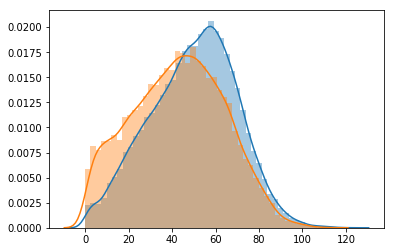

In [11]:
import seaborn as sns

cluster_stats ={}

cluster_stats['hue_std'] = X_morph[:,0]
cluster_stats['sat_std'] = X_morph[:,1]
cluster_stats['li_std'] = X_morph[:,2]
cluster_stats['hue_mean'] = X_morph[:,3]
cluster_stats['sat_mean'] = X_morph[:,4]
cluster_stats['li_mean'] = X_morph[:,5]
cluster_stats['hue_mode'] = X_morph[:,6]
cluster_stats['sat_mode'] = X_morph[:,7]
cluster_stats['li_mode'] = X_morph[:,8]

cluster_stats_control ={}

cluster_stats_control['hue_std'] = X_morph_control[:,0]
cluster_stats_control['sat_std'] = X_morph_control[:,1]
cluster_stats_control['li_std'] = X_morph_control[:,2]
cluster_stats_control['hue_mean'] = X_morph_control[:,3]
cluster_stats_control['sat_mean'] = X_morph_control[:,4]
cluster_stats_control['li_mean'] = X_morph_control[:,5]
cluster_stats_control['hue_mode'] = X_morph_control[:,6]
cluster_stats_control['sat_mode'] = X_morph_control[:,7]
cluster_stats_control['li_mode'] = X_morph_control[:,8]


sns.distplot(cluster_stats_control['li_std'])


sns.distplot(cluster_stats['li_std'])

In [139]:

# trial = []

# for cluster_range in range(8,20):

#     y_pred = KMeans(n_clusters=cluster_range, random_state=random_state).fit_predict(X_morph)
#     print('Testing Cluster range:',cluster_range)
    
#     cluster_search = {}
#     for i in range(cluster_range):

#         cluster_stats = {}

#         X_morph_stats = np.mean(X_morph[y_pred==i], axis=0)
#         cluster_stats['hue_std'] = X_morph_stats[0]
#         cluster_stats['sat_std'] = X_morph_stats[1]
#         cluster_stats['li_std'] = X_morph_stats[2]
#         cluster_stats['hue_mean'] = X_morph_stats[3]
#         cluster_stats['sat_mean'] = X_morph_stats[4]
#         cluster_stats['li_mean'] = X_morph_stats[5]
#         cluster_stats['hue_mode'] = X_morph_stats[6]
#         cluster_stats['sat_mode'] = X_morph_stats[7]
#         cluster_stats['li_mode'] = X_morph_stats[8]

#         cluster_search[i] = cluster_stats
    
#     trial.append(cluster_search)

Testing Cluster range: 8
Testing Cluster range: 9
Testing Cluster range: 10
Testing Cluster range: 11
Testing Cluster range: 12
Testing Cluster range: 13
Testing Cluster range: 14
Testing Cluster range: 15
Testing Cluster range: 16
Testing Cluster range: 17
Testing Cluster range: 18
Testing Cluster range: 19


In [140]:
print(trial)


[{0: {'hue_std': 22.00260558214417, 'sat_std': 37.62338129290334, 'li_std': 41.54743938321491, 'hue_mean': 22.00260558214417, 'sat_mean': 37.62338129290334, 'li_mean': 41.54743938321491, 'hue_mode': 30.066479275049815, 'sat_mode': 108.04315098613831, 'li_mode': 77.01553227900477}, 1: {'hue_std': 23.877025611366218, 'sat_std': 18.625374827744103, 'li_std': 30.21220960901334, 'hue_mean': 23.877025611366218, 'sat_mean': 18.625374827744103, 'li_mean': 30.21220960901334, 'hue_mode': 26.124786884375872, 'sat_mode': 24.289450149775888, 'li_mode': 205.30253280248397}, 2: {'hue_std': 21.660926077725914, 'sat_std': 48.19759159115698, 'li_std': 47.19059185402931, 'hue_mean': 21.660926077725914, 'sat_mean': 48.19759159115698, 'li_mean': 47.19059185402931, 'hue_mode': 40.774183677972395, 'sat_mode': 139.04209126819765, 'li_mode': 156.08339231634415}, 3: {'hue_std': 34.309902629918525, 'sat_std': 33.73850848186347, 'li_std': 41.801706581355795, 'hue_mean': 34.309902629918525, 'sat_mean': 33.73850848

{0: {'hue_std': 39.42100274985669, 'sat_std': 43.12219522514177, 'li_std': 56.157314324720204, 'hue_mean': 39.42100274985669, 'sat_mean': 43.12219522514177, 'li_mean': 56.157314324720204, 'hue_mode': 43.01817188755503, 'sat_mode': 66.76339905382167, 'li_mode': 92.53005742670663}}


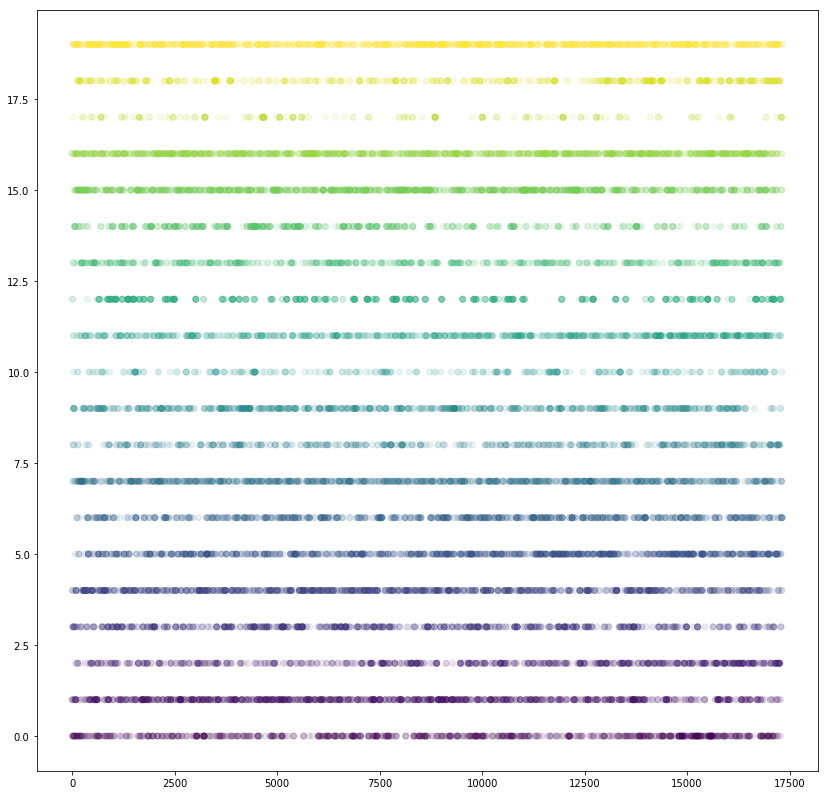

In [122]:
import cv2
#print(y_pred[0:100])

for i in range(5000):

    img = X[i].reshape(int(len(X[i]) / 90),int(len(X[i]) / 90),3 ).astype('uint8')
    
    if y_pred[i] == 17:
        cv2.imshow('image',img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
plt.figure(figsize=(14, 14))
plt.scatter(range(len(y_pred)), y_pred, c=y_pred,alpha=0.1)

plt.show()

In [33]:
#X,y = load_data()

Loaded json models
Loaded json models
target length 44400
control length 44016
max length 44015


In [34]:
#X_train, X_test, y_train, y_test = test_split(X,y)

In [35]:
#generate_model(X_train, X_test, y_train, y_test)

Training size: 58980
Testing size: 29050
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=6)]: Done   2 out of   2 | elapsed: 14.2min finished
D:\anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\anaconda\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


best params: {'pca__n_components': 0.89, 'rforest__bootstrap': True, 'rforest__max_depth': 110, 'rforest__max_features': 0.3, 'rforest__min_samples_leaf': 3, 'rforest__min_samples_split': 8, 'rforest__n_estimators': 1200}


D:\anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


             precision    recall  f1-score   support

        0.0       0.70      0.70      0.70     14551
        1.0       0.70      0.70      0.70     14499

avg / total       0.70      0.70      0.70     29050



True

In [ ]:
grayscale
{'pca__n_components': 0.93,
 'rforest__bootstrap': True,
 'rforest__max_depth': 110,
 'rforest__max_features': 0.3,
 'rforest__min_samples_leaf': 3,
 'rforest__min_samples_split': 8,
 'rforest__n_estimators': 1200}

In [ ]:
color

{'pca__n_components': 0.87,
 'rforest__bootstrap': True,
 'rforest__max_depth': 110,
 'rforest__max_features': 0.3,
 'rforest__min_samples_leaf': 3,
 'rforest__min_samples_split': 8,
 'rforest__n_estimators': 1200}